# Calibration within jupyter notebooks

This notebook presents a very simple GUI for doing the calibration of diffraction setup within the Jupyter environment with Matplotlib and Ipywidgets.

Despite this is in the `cookbook` section, this **tutorial** requires advanced Python programming knowledge and some good understanding of `PyFAI`. 

The basic idea is to port, more or less directly, the `pyFAI-calib` interface which was done with matplotlib into the Jupyter notebook. 

The PeakPicker class has been addapted and this notebook presents mainly its usage.

Most credits go *Philipp Hans* for the adaptation of the origin PeakPicker class to Jupyter.

In [1]:
%matplotlib nbagg
import pyFAI
import logging
logging.basicConfig(level=logging.INFO)
import pyFAI.test.utilstest
import fabio
from matplotlib.pyplot import subplots
from ipywidgets import *
from pyFAI.gui import jupyter
from pyFAI.gui.jupyter.peak_picker import PeakPicker
from pyFAI.geometryRefinement import GeometryRefinement

In [2]:
# Some parameters like the wavelength, the calibrant and the diffraction image (downloaded from internet)
wavelength = 1e-10
pilatus = pyFAI.detector_factory("Pilatus1M")
AgBh = pyFAI.calibrant.CALIBRANT_FACTORY("AgBh")
AgBh.wavelength = wavelength

img = pyFAI.test.utilstest.UtilsTest.getimage("Pilatus1M.edf")
fimg = fabio.open(img)
image = fimg.data

<IPython.core.display.Javascript object>


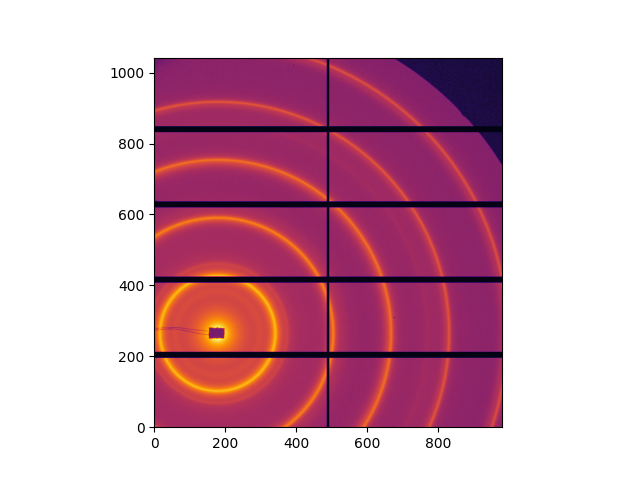

In [3]:
#Simple display of the image:
_ = jupyter.display(image)

1. Shift + left-click to pick a set of point 
2. Click "assign group" to the ring numner (0-based!)
then you click merge
3. Click save to expose the control points


<IPython.core.display.Javascript object>


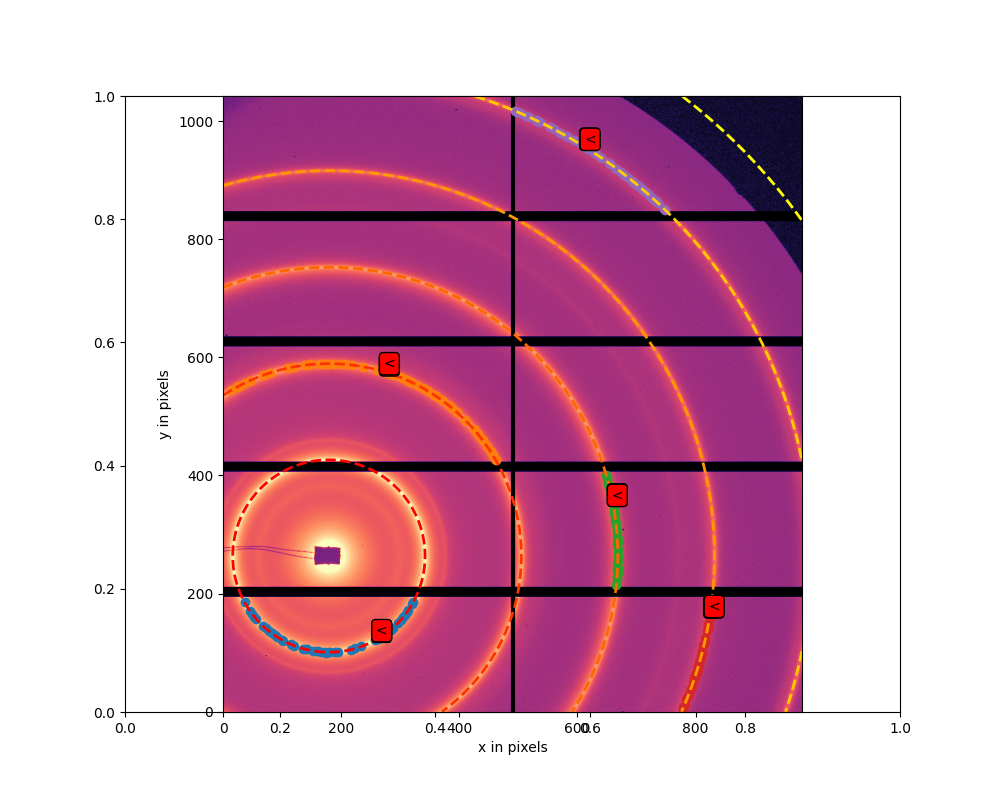

In [5]:
#PeakPicker is used in the same way as the one in the CLI.

pp = PeakPicker(data=fimg.data, calibrant=AgBh, wavelength=wavelength, detector=pilatus)

pp.gui(log=True)

In [6]:
pp.points

ControlPoints instance containing 5 group of point:
AgBh Calibrant with 49 reflections at wavelength 1e-10
Containing 5 groups of points:
# f ring 0: 47 points
# g ring 1: 56 points
# h ring 2: 38 points
# i ring 3: 38 points
# j ring 4: 43 points

In [7]:
gr = GeometryRefinement(pp.points.getList(), 
                        detector=pilatus, 
                        calibrant=AgBh, 
                        wavelength=wavelength)
gr.refine3()
print(gr)

Detector Pilatus 1M	 PixelSize= 1.720e-04, 1.720e-04 m
Wavelength= 1.000237e-10m
SampleDetDist= 1.633931e+00m	PONI= 3.578310e-02, 1.050102e-02m	rot1=-0.012477  rot2= 0.005898  rot3= -0.000000 rad
DirectBeamDist= 1634.087mm	Center: x=179.586, y=264.077 pix	Tilt=0.791 deg  tiltPlanRotation= 25.302 deg


In [8]:
pp.contour(gr.array_from_unit(scale=False))

Visually check that the overlaid dashed curve on the Debye-Sherrer rings of the image
Check also for correct indexing of rings
